<a href="https://colab.research.google.com/github/electricshadok/notebooks/blob/main/energy_based_model_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Understanding Energy-Based Models (EBM) and Langevin Dynamics

An **Energy-Based Model (EBM)** that learns a 2D distribution and uses **Langevin Dynamics** for sampling:

- **Objective**: Learn a 2D probability distribution (e.g., Gaussian mixture) using an EBM.
- **Input**: Points in a 2D space.
- **Output**: An energy function that assigns low values to high-probability regions and high values to low-probability regions.

## Packages

In [52]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## 1. Generate Synthetic Data

We create a dataset of 2D points sampled from a Gaussian Mixture Model (GMM). This simulates data from a real-world distribution that we want the EBM to learn.

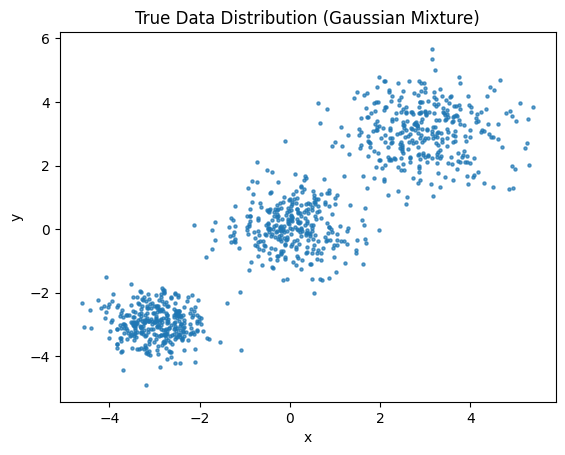

In [53]:
NUM_POINTS = 1000  # Total number of points
SEED = 42  # Seed for reproducibility

# Create synthetic data: Gaussian mixture
def sample_gaussian_mixture(n_samples, means, covs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n_components = len(means)
    samples = []
    for _ in range(n_samples):
        k = np.random.choice(n_components)  # Randomly select one Gaussian component
        sample = np.random.multivariate_normal(means[k], covs[k])
        samples.append(sample)
    return np.array(samples)

# Parameters of the Gaussian mixture
means = [[0, 0], [3, 3], [-3, -3]]
covs = [np.eye(2) * 0.5, np.eye(2) * 0.8, np.eye(2) * 0.3]

# Generate data
X = sample_gaussian_mixture(NUM_POINTS, means, covs, seed=SEED)

# Visualize the synthetic data
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.7)
plt.title("True Data Distribution (Gaussian Mixture)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 2. Energy-Based Model (EBM)

The Energy-Based model (EBM) learns a scalar-valued energy function $E(x, y)$.

$$p(x, y) \propto \exp(-E(x, y))$$


- $E(x, y)$ : Energy function.
- $p(x,y)$ : Probability density (unnormalized).

The goal is to train the energy function so that it assigns:
- Low energy to real data points.
- High energy to fake data points.

We are using a neural network to represent the energy function $E(x, y)$. The neural network receives a 2D input and return the scalar energy value.

In [55]:
class EnergyModel(nn.Module):
    def __init__(self, input_dim):
        super(EnergyModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

# Instantiate the model
energy_model = EnergyModel(input_dim=2)


## 3. Train the Energy Model

Train the energy function to minimize energy for real data points and maximize energy for model-generated fake data points.

Use **Contrastive Divergence** (CD) to train the model

$$L = \mathbb{E}_{\text{data}}[E(x)] - \mathbb{E}_{\text{model}}[E(x)]$$


- Minimize energy for real data.
- Maximize energy for model-generated samples (fake data).


Sampling formula with Langevin Dynamics

$$x_{t+1} = x_t - \eta \nabla_x E(x_t) + \sqrt{2\eta} \cdot \epsilon$$

- $\eta$ : Step size.
- $\nabla_x E(x_t)$ : Gradient of the energy function.
- $\epsilon$ : Gaussian noise $\epsilon \sim N(0, I)$


In [56]:
# Training Loop
NUM_EPOCHS = 500
BATCH_SIZE = 128
STEP_SIZE = 0.1
LANGEVIN_STEPS = 20

# Optimizer
optimizer = torch.optim.Adam(energy_model.parameters(), lr=0.001)

# Langevin Sampling
def langevin_sampling(energy_model, init_samples, langevin_steps, step_size):
    # TODO: review langevin_sampling
    samples = init_samples.clone().detach()
    samples.requires_grad = True
    for _ in range(langevin_steps):
        # Compute energy
        energy = energy_model(samples) # shape [BATCH_SIZE]
        # Computes the gradient of the total energy
        energy_grad = torch.autograd.grad(energy.sum(), samples)[0] # shape [BATCH_SIZE, 2]
        # Update samples
        samples = samples - step_size * energy_grad + math.sqrt(2 * step_size) * torch.randn_like(samples)
    return samples.detach()

X_tensor = torch.tensor(X, dtype=torch.float32)
for epoch in range(NUM_EPOCHS):
    # Sample real data
    idx = np.random.randint(0, len(X), size=BATCH_SIZE)
    real_data = X_tensor[idx]

    # Sample fake data using Langevin dynamics
    init_samples = torch.randn(BATCH_SIZE, 2)  # Start from random noise
    fake_data = langevin_sampling(energy_model, init_samples, LANGEVIN_STEPS, STEP_SIZE)

    # Compute energy
    real_energy = energy_model(real_data)
    fake_energy = energy_model(fake_data)

    # Loss: Maximize energy for fake samples, minimize for real samples
    loss = (real_energy.mean() - fake_energy.mean())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.04705851525068283
Epoch 50, Loss: 0.05121254920959473
Epoch 100, Loss: -0.07915186882019043
Epoch 150, Loss: -0.3107006549835205
Epoch 200, Loss: -0.7077932357788086
Epoch 250, Loss: -0.4658050537109375
Epoch 300, Loss: 0.003233477473258972
Epoch 350, Loss: 0.31380605697631836
Epoch 400, Loss: -0.6086549758911133
Epoch 450, Loss: -0.34336864948272705


## 4. Sample Energy Model with Langevin Dynamics

The trained energy model generates new samples that approximate the true data distribution.

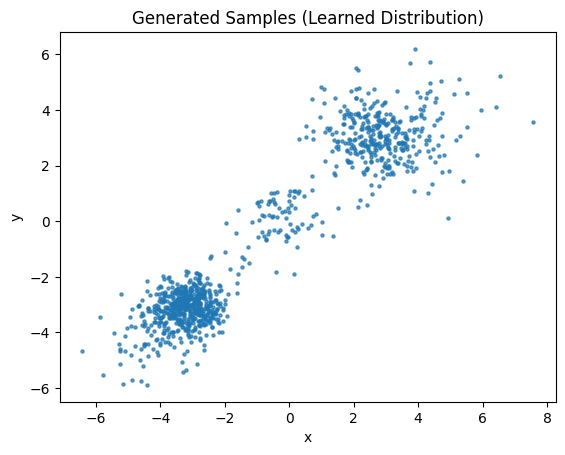

In [57]:
# Generate samples
n_samples = 1000
init_samples = torch.randn(n_samples, 2)
generated_samples = langevin_sampling(energy_model, init_samples, langevin_steps=50, step_size=0.1)

# Visualize generated samples
generated_samples_np = generated_samples.detach().numpy()
plt.scatter(generated_samples_np[:, 0], generated_samples_np[:, 1], s=5, alpha=0.7)
plt.title("Generated Samples (Learned Distribution)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 5. Visualizing the Energy Landscape

The energy function $E(x, y)$ can be plotted to show how the model has learned the probability density.

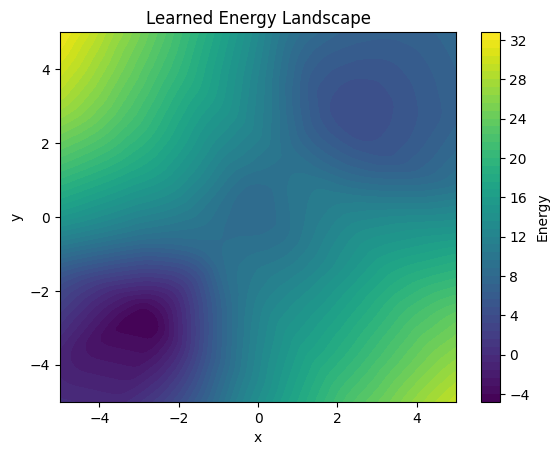

In [58]:
# Plot energy landscape
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(x, y)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    energies = energy_model(grid).numpy()

energies = energies.reshape(xx.shape)
plt.contourf(xx, yy, energies, levels=50, cmap="viridis")
plt.title("Learned Energy Landscape")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="Energy")
plt.show()